# Figure 4 - Multifrequency HD 209458b
Ignore the warning about conductive cooling for the monofrequency solution. That result is from Murray-Clay et al. (2009) and does not include the physics of the region below the wind.

In [12]:
from wind_ae.wrapper.relax_wrapper import wind_simulation as wind_sim
from wind_ae.wrapper.wrapper_utils.plots import _custom_rc_params

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
sim0 = wind_sim()
sim0.load_uservars('data/MC09_lo_mono.csv')

sim_mono = wind_sim()
sim_mono.load_uservars('data/HD209_mono-20eV_H.csv')

sim_EUV = wind_sim()
sim_EUV.load_uservars('data/HD209_13.6-100eV_H.csv')

sim_XUV = wind_sim()
sim_XUV.load_planet('data/HD209_13.6-2000eV_H.csv')

         Wind-AE does not currently model conductive cooling. 
         Plot energy_plot(all_terms=True) to check.
Atmosphere Composition
  Species:   HI
  Mass frac: 1.00e+00



In [16]:
def quick_plot(soln, Mdot_legend=True, line_color='k', line_style='-', line_label='',label_dim=[0,1.3,2],
             ion_label=True,first_plotted=False, ax=0, shortlabel=''): 
    '''
    Description: 
        Plots density (g/cm3), temperature (K), velocity (10 km/s), 
        ionization fraction as a function of r (Rp).
        
    Arguments:
        soln - windsoln object (sim.windsoln)
        Mdot_legend - Bool; if True, put Mdot in legend of plot. Else, just prints.
        line_color - str; line color 
        line_style - str; line style
        label_dim - list; default=[0,1.3,2]. Location of label and ncols [x,y,ncols]. 
        first_plotted - Bool; True if this the first of many Four plots 
                        to be plotted on the same axes. 
    Returns:
        ax - axes object (if first_plotted=True)
        title
    '''
    try: # Check if R_cori has be calculated. If not, calculate all post-facto user variables
        soln.R_cori
    except AttributeError:
        if soln.integrate_outward == 0:
            soln.R_cori = 1e10
        else:
            soln.add_user_vars()
    
    radius_norm = 1.0
    alpha=0.5
    radius = soln.soln_norm['r']
    R_H = soln.semimajor*(soln.Mp/(3*soln.Mstar))**(1/3) / soln.Rp
    nspecies = soln.nspecies

    colormap,custom_cycler,fontsize,columns = _custom_rc_params(line_color,nspecies)

    stack=2
    if first_plotted==True:
        fig, ax = plt.subplots(stack,2,sharex=True,figsize=[11,6])
        fig.subplots_adjust(hspace=0)
        ax[0,0].axvline(radius_norm*(soln.soln_norm['z'][1]+1.),
                        c=line_color, alpha=alpha, ls='--', zorder=3,label='Sonic Point')
        ax[0,0].axvline(R_H,ls=':',c=line_color,label='Hill Radius')

    ax[0,0].semilogy(soln.soln_norm['r'], soln.soln['rho'],lw=2,c=line_color,ls=line_style)
    ax[0,0].set_ylabel(r'Density (g/cm$^3$)')
    ax[0,0].set_ylim(top=1e-11)
    ax[0,0].legend(loc='upper right')
 
    #Velocity 
    ax[1,0].plot(soln.soln_norm['r'], soln.soln['v']/1e6,lw=2,c=line_color,ls=line_style)
    ax[1,0].set_ylabel(r'Velocity (10 km/s)')
    
    #Temperature
    mdot = (soln.Mdot)#/const.Msun)*3.154e+7 #in Msun/year
    print(f'*****{line_label:s} Mdot = {mdot:.2e} g/s ******')
    ax[0,1].plot(soln.soln_norm['r'], soln.soln['T']/1000,lw=2,c=line_color,ls=line_style)
    ax[0,1].set_ylim(np.min(soln.soln['T']/1000)*0.97,np.max(soln.soln['T']/1000)*1.03)
    ax[0,1].set_ylabel(r'Temperature (1000 K)')
    ax[0,1].set_yscale('log')
    ax[0,1].get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    ax[0,1].get_yaxis().set_minor_formatter(ticker.ScalarFormatter())
    title = ''
    for j,spname in enumerate(soln.species_list):
        spname = spname.replace(' ','')
        ax[1,1].semilogy(soln.soln_norm['r'],
                         1-soln.soln['Ys_'+spname],lw=2,label=shortlabel+f' {mdot:.1e} g/s',
                         ls=line_style,c=line_color)
    ax[1,1].set_ylabel(r'Ionization Fraction')
    ax[1,1].set_ylim((1e-2,0.99999999))
    leg = ax[1,1].legend(edgecolor='k',fontsize=14)
    leg.get_frame().set_linewidth(1.5)    #Ionization fraction

    #Plotting shared lines
    if soln.Rmax > soln.R_cori:
        if first_plotted==False:
            ax[0,0].fill_betweenx((0,np.max(soln.soln['rho'])),
                                  soln.R_cori,soln.Rmax,alpha=0.3,color=line_color)
        ax[0,1].fill_betweenx((0,np.max(soln.soln['T'])),
                              soln.R_cori,soln.Rmax,alpha=0.3,color=line_color)
        ax[1,0].fill_betweenx((0,np.max(soln.soln['v']/(10*100*1000))),
                              soln.R_cori,soln.Rmax,alpha=0.3,color=line_color)
        ax[1,1].fill_betweenx((0,1),soln.R_cori,soln.Rmax,alpha=0.3,color=line_color)
    for k in range(2):
        ax[1,k].set_xlabel(r'Radius (R$_p$)')
        for m in range(stack):
            ax[m,k].axvline(radius_norm*(soln.soln_norm['z'][1]+1.),
                             c=line_color, alpha=alpha, ls='--', zorder=3)
            ax[m,k].axvline(R_H,ls=':',c=line_color)
    plt.gca().set_xlim(left=soln.Rmin)
    if first_plotted==True:
        return ax

***** Mdot = 6.34e+09 g/s ******
***** Mdot = 1.42e+10 g/s ******
***** Mdot = 4.24e+10 g/s ******
***** Mdot = 4.14e+10 g/s ******


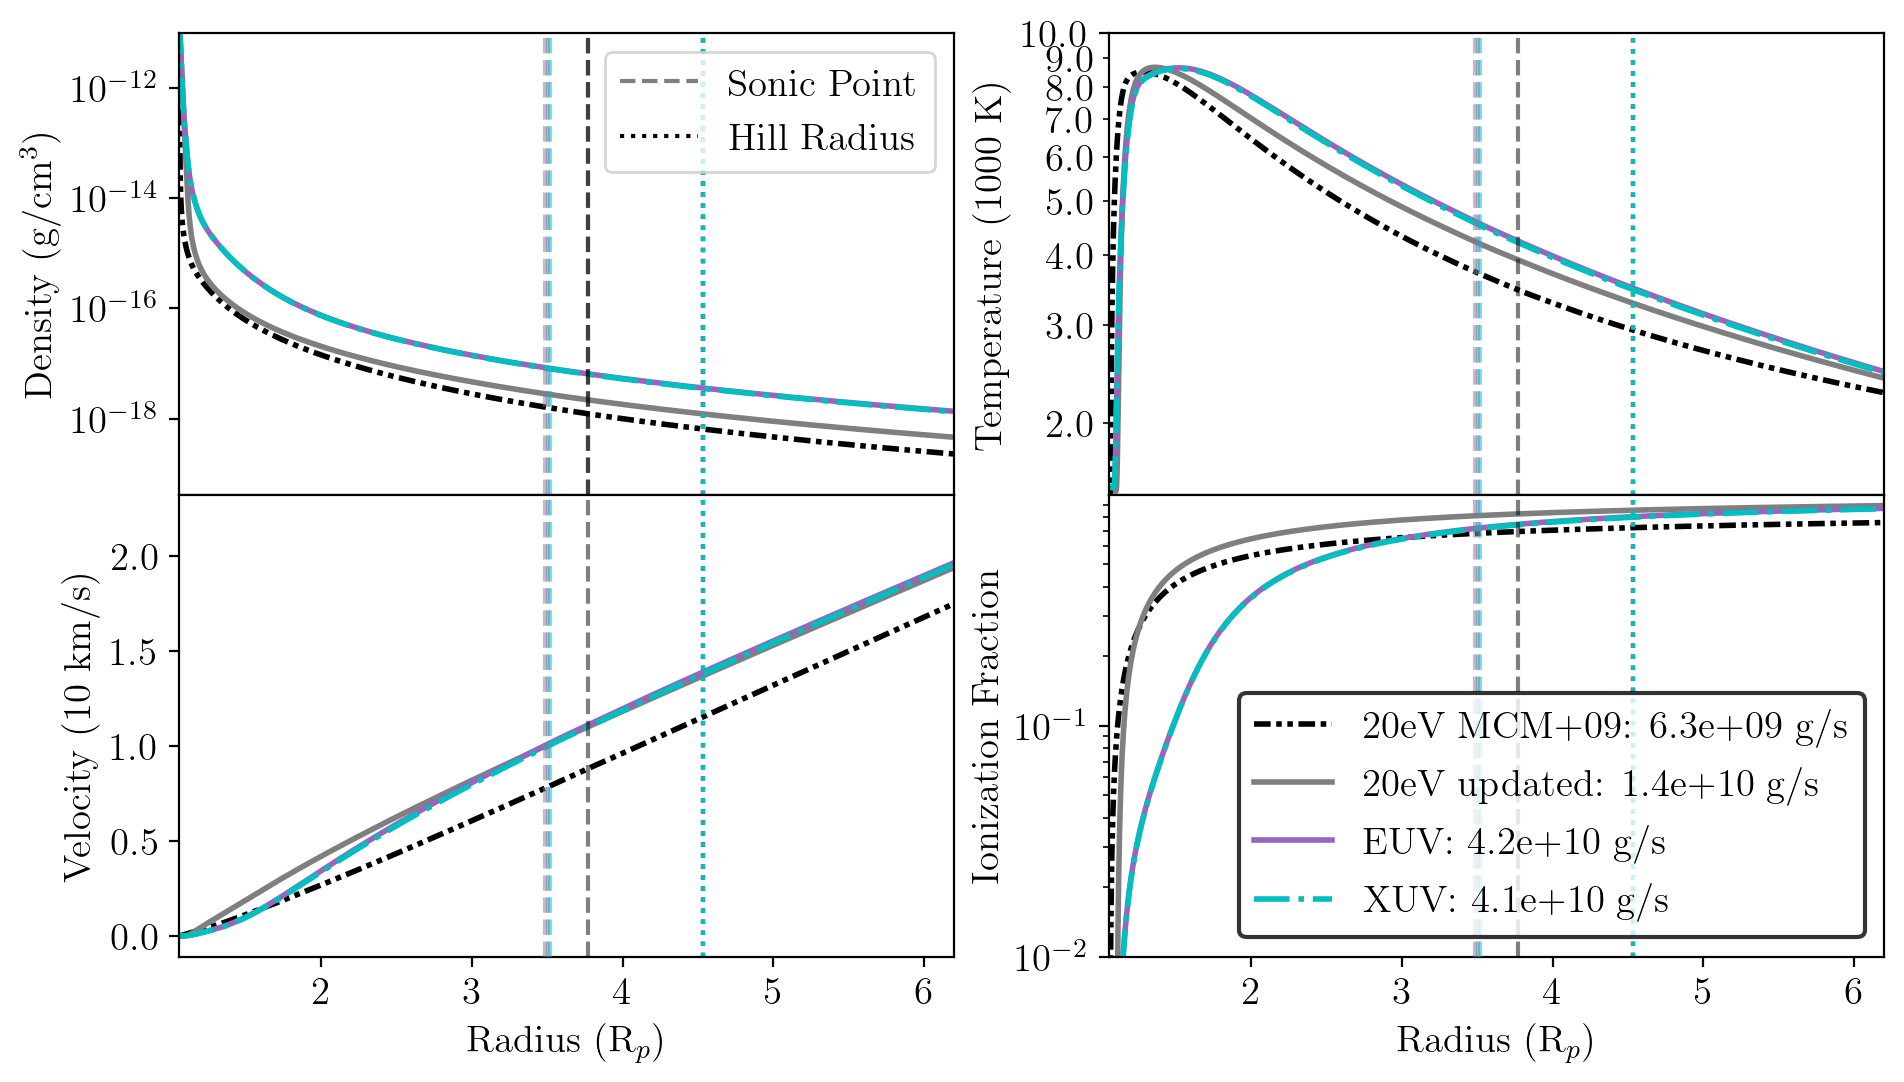

In [ ]:
label_arr = [-0.2,1.4,2]
ax = quick_plot(sim0.windsoln,first_plotted=True,line_style=(0, (3, 1, 1, 1, 1, 1)),line_color='k',
              ion_label=False,
        shortlabel="20eV MCM+09:",
              label_dim=label_arr)
quick_plot(sim_mono.windsoln,ax=ax,line_color='tab:gray',ion_label=False,
        shortlabel=r'20eV updated: ',
         label_dim=label_arr)
quick_plot(sim_EUV.windsoln,ax=ax,line_color='tab:purple',ion_label=False,
        shortlabel='EUV:     ',
         label_dim=label_arr)
quick_plot(sim_XUV.windsoln,ax=ax,line_color='c',line_style='dashdot',ion_label=False,
        shortlabel='XUV:     ',
         label_dim=label_arr)
ax[0,1].set_ylim(top=10)

plt.xlim(right=6.2)

plt.show()

Difference in temperature
* Larger total flux + larger spectral range

Difference in density 
* Larger spectral range 

Difference in ionization 
* Larger spectral range

Difference in velocity
* Larger total flux

Mdot
* Larger total flux 

---
More relative ly-alpha cooling when larger total flux. Only a little more when larger spectral range